# Divisions and ISMT
This notebook match each point of the dataset presented in the "Exploratory Data Analysis" notebook to a node in a Santiago Drive Graph obtained with Open Street Map.

In [2]:
import osmnx as ox
import networkx as nx
from datetime import timedelta
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
sns.set(style='darkgrid')

## Add new feature node id column
In this study, we have two datasets that need to be integrated. On one hand, we have our dataset presented in the "Exploratory Data Analysis" notebook, and on the other hand, an OpenStreetMap map of the city of Santiago.

Each row within our dataset needs to be paired with a corresponding node in OpenStreetMap. This merging process combines Santiago's graph structure with attribute values unique to each node. It's noteworthy that a single node on the Santiago map can be associated with multiple rows from the dataset.

In [3]:
G = ox.load_graphml("Maps/temuco_drive.graphml")
print(f'Number of nodes: {len(G.nodes())}')
print(f'Number of edges: {len(G.edges())}')

Number of nodes: 29022
Number of edges: 56332


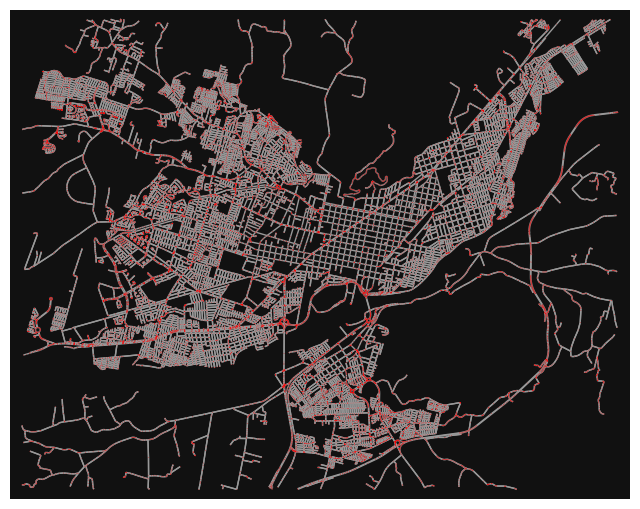

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(G, node_size=0.2, edge_linewidth=1, show=True, node_color='red')

In [5]:
df = pd.read_csv('Data/vars_perceptuales_temuco.csv')
len(df)

16552

In [11]:
%%time
nodes_id = []
for _, row in tqdm(df.iterrows()):
    node = ox.distance.nearest_nodes(G, row.lon, row.lat)
    nodes_id.append(node)

df['node_id'] = nodes_id

16552it [37:07,  7.43it/s]

CPU times: total: 13min 10s
Wall time: 37min 7s


In [12]:
df.to_csv('Data/dataset_temuco_nodes.csv', index=False)

## Find Administrative Division for each point

In [7]:
chile_division = gpd.read_file('Data/Comunas/COMUNAS_2020.shp')
chile_division.head()

,CUT_REG,CUT_PROV,CUT_COM,REGION,PROVINCIA,COMUNA,SUPERFICIE,geometry
0,01,011,01101,Tarapacá,Iquique,Iquique,2289.53,"MULTIPOLYGON (((-70.11528 -21.17792, -70.11540..."
1,01,011,01107,Tarapacá,Iquique,Alto Hospicio,571.19,"POLYGON ((-69.92603 -20.25000, -69.96762 -20.3..."
2,01,014,01401,Tarapacá,Tamarugal,Pozo Almonte,13765.80,"POLYGON ((-68.99185 -19.92108, -68.98991 -19.9..."
3,01,014,01402,Tarapacá,Tamarugal,Camiña,2199.83,"POLYGON ((-69.39521 -19.06188, -69.39385 -19.0..."
4,01,014,01403,Tarapacá,Tamarugal,Colchane,4007.84,"POLYGON ((-68.65146 -19.77181, -68.65148 -19.7..."


<Axes: >

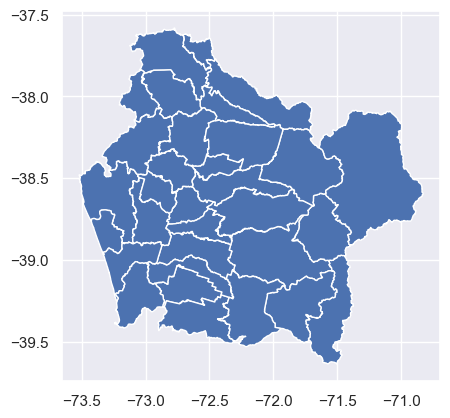

In [8]:
santiago_division = chile_division[chile_division.CUT_REG == '09']
santiago_division.plot()

In [6]:
santiago_values = pd.read_csv('Data/dataset_temuco_nodes.csv')
santiago_values = gpd.GeoDataFrame(santiago_values, geometry=gpd.points_from_xy(santiago_values.lon,santiago_values.lat))
santiago_values.head(3)


,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,node_id,geometry
0,"-38.697697,-72.53198748",0.445180,0.289217,-0.149913,-0.445436,-0.039854,-0.002562,-38.697697,-72.531987,6008448745,POINT (-72.53199 -38.69770)
1,"-38.697697,-72.53261330666666",-0.163581,0.548523,0.346155,-0.694804,-0.333746,-0.454411,-38.697697,-72.532613,6008448745,POINT (-72.53261 -38.69770)
2,"-38.697697,-72.53323913333332",0.403311,0.391432,-0.143103,-0.274460,0.284255,0.237283,-38.697697,-72.533239,6148151723,POINT (-72.53324 -38.69770)


In [9]:
def get_division(point) -> str:
    for com in santiago_division.geometry:
        if point.within(com):
            return com

tqdm.pandas()
santiago_values['division'] = santiago_values.geometry.progress_apply(get_division)

100%|██████████| 16552/16552 [00:08<00:00, 1859.12it/s]


In [10]:
santiago_division.head(3)

,CUT_REG,CUT_PROV,CUT_COM,REGION,PROVINCIA,COMUNA,SUPERFICIE,geometry
162,09,091,09101,La Araucanía,Cautín,Temuco,466.89,"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5..."
163,09,091,09102,La Araucanía,Cautín,Carahue,1336.81,"POLYGON ((-73.05864 -38.47723, -73.05889 -38.4..."
164,09,091,09103,La Araucanía,Cautín,Cunco,1890.34,"POLYGON ((-71.56104 -39.00273, -71.56083 -39.0..."


In [11]:
santiago_with_divisions = santiago_values.merge(santiago_division[['geometry', 'COMUNA']], left_on='division', right_on='geometry')

In [20]:
santiago_with_divisions = santiago_with_divisions.drop(['geometry_x', 'division', 'geometry_y'], axis=1)
santiago_with_divisions = santiago_with_divisions.rename({'COMUNA':'division'}, axis=1)

In [21]:
santiago_with_divisions.to_csv('Data/dataset_temuco.csv', index=False)

In [52]:
df = pd.read_csv('Data/dataset_temuco.csv')
df.head()

,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,node_id,division
0,"-38.697697,-72.53198748",0.445180,0.289217,-0.149913,-0.445436,-0.039854,-0.002562,-38.697697,-72.531987,6008448745,Temuco
1,"-38.697697,-72.53261330666666",-0.163581,0.548523,0.346155,-0.694804,-0.333746,-0.454411,-38.697697,-72.532613,6008448745,Temuco
2,"-38.697697,-72.53323913333332",0.403311,0.391432,-0.143103,-0.274460,0.284255,0.237283,-38.697697,-72.533239,6148151723,Temuco
3,"-38.697697,-72.54387818666666",0.161203,0.276770,0.034872,-0.347860,-0.015384,-0.065595,-38.697697,-72.543878,5157534917,Temuco
4,"-38.697697,-72.54450401333332",-0.222312,0.038146,0.137342,0.006346,-0.003721,-0.042701,-38.697697,-72.544504,5157534917,Temuco


## Find ISMT values

In [41]:
df_ismt = gpd.read_file('Data/ISMT_Temuco/ISMT_Temuco.shp')
df_ismt.head(2)

,FID,zona,REGION_,NOM_REG,PROVINC,NOM_PRO,COMUNA_,NOM_COM,URBANO,DISTRIT,...,hacin_n,alleg,escolar,mat_cpt,mat_rcp,mat_rrc,ind_mat,Shape__Are,Shape__Len,geometry
0,1,9101011001,9,REGIÓN DE LA ARAUCANÍA,91,CAUTÍN,9101,TEMUCO,TEMUCO,1,...,545,85,12.970890,485,97,2,8.806507,1.039618e+06,6664.907891,"POLYGON ((-8081433.100 -4683110.882, -8081430...."
1,2,9101011002,9,REGIÓN DE LA ARAUCANÍA,91,CAUTÍN,9101,TEMUCO,TEMUCO,1,...,1417,194,14.854181,1382,65,0,8.954388,9.677756e+05,4449.304735,"POLYGON ((-8080980.952 -4683920.402, -8081011...."


In [44]:
#!pip install contextily
!pip --q install pyproj
#from pyproj import Transformer


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import contextily as ctx
from pyproj import Transformer

gdf_3857 = df_ismt.to_crs(epsg=3857)
#crit_hab_polys = gdf_3857.plot(column='zona', figsize=(10,10))

In [54]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
lats_trans = []
lons_trans = []
for idx, row in df.iterrows():
    new_lat, new_lon = transformer.transform(row.lat, row.lon)
    lats_trans.append(new_lat)
    lons_trans.append(new_lon)
#transformer.transform(-8081433.100,-4683110.882)
df['lat_trans'] = lats_trans
df['lon_trans'] = lons_trans


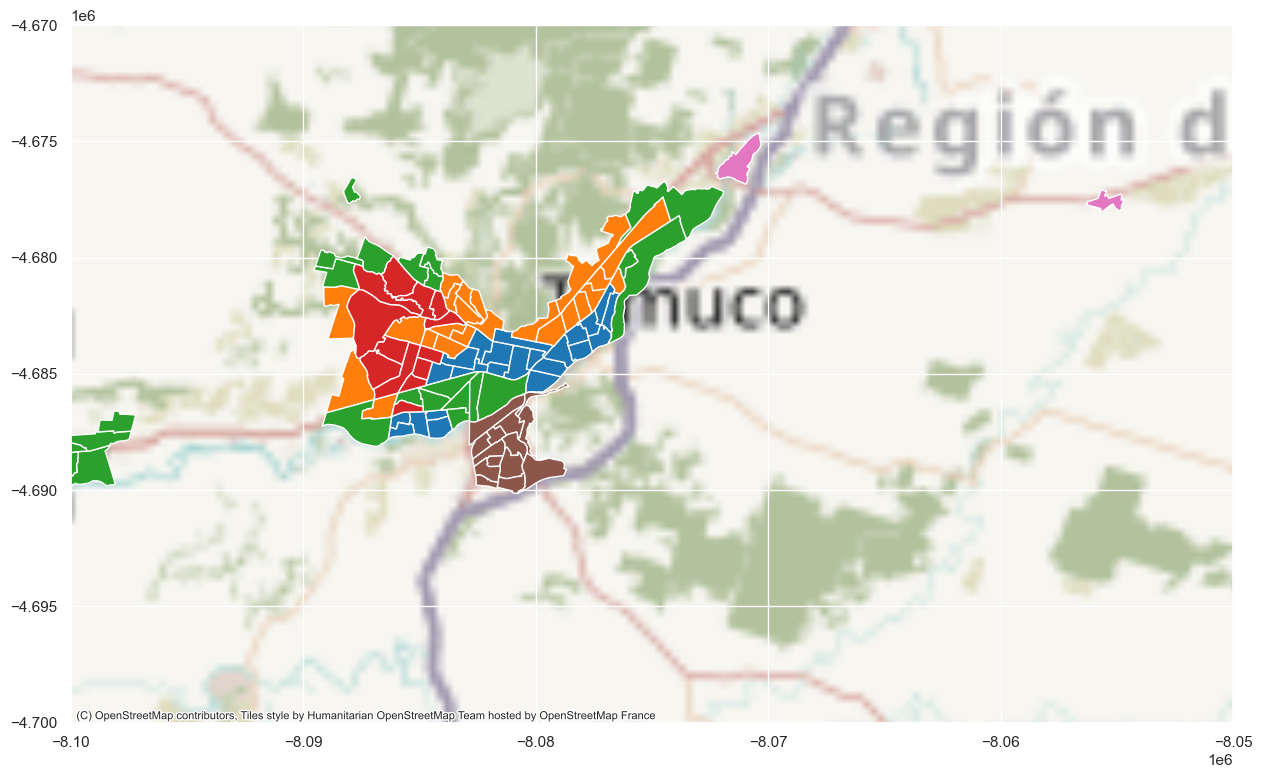

In [56]:
gdf_3857 = df_ismt.to_crs(epsg=3857)
crit_hab = gdf_3857.plot(column='zona', figsize=(15,15))
ctx.add_basemap(crit_hab)
plt.ylim([-4700000, -4670000])
plt.xlim([-8100000, -8050000])
plt.show()

In [63]:
df_ismt.head(2)

,FID,zona,REGION_,NOM_REG,PROVINC,NOM_PRO,COMUNA_,NOM_COM,URBANO,DISTRIT,...,hacin_n,alleg,escolar,mat_cpt,mat_rcp,mat_rrc,ind_mat,Shape__Are,Shape__Len,geometry
0,1,9101011001,9,REGIÓN DE LA ARAUCANÍA,91,CAUTÍN,9101,TEMUCO,TEMUCO,1,...,545,85,12.970890,485,97,2,8.806507,1.039618e+06,6664.907891,"POLYGON ((-8081433.100 -4683110.882, -8081430...."
1,2,9101011002,9,REGIÓN DE LA ARAUCANÍA,91,CAUTÍN,9101,TEMUCO,TEMUCO,1,...,1417,194,14.854181,1382,65,0,8.954388,9.677756e+05,4449.304735,"POLYGON ((-8080980.952 -4683920.402, -8081011...."


In [64]:
def get_ismt_data(point):
    for com in df_ismt.geometry:
        if point.within(com):
            return com

tqdm.pandas()
coords_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lat_trans, df.lon_trans))
coords_point['geo_ismt'] = coords_point.geometry.progress_apply(get_ismt_data)

  0%|          | 0/16552 [00:00<?, ?it/s]

100%|██████████| 16552/16552 [00:15<00:00, 1095.72it/s]


In [65]:
coords_point

,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,node_id,division,lat_trans,lon_trans,geometry,geo_ismt
0,"-38.697697,-72.53198748",0.445180,0.289217,-0.149913,-0.445436,-0.039854,-0.002562,-38.697697,-72.531987,6008448745,Temuco,-8.074224e+06,-4.678461e+06,POINT (-8074223.912 -4678461.305),"POLYGON ((-8074297.170 -4679646.811, -8074336...."
1,"-38.697697,-72.53261330666666",-0.163581,0.548523,0.346155,-0.694804,-0.333746,-0.454411,-38.697697,-72.532613,6008448745,Temuco,-8.074294e+06,-4.678461e+06,POINT (-8074293.579 -4678461.305),"POLYGON ((-8074432.742 -4677665.833, -8074339...."
2,"-38.697697,-72.53323913333332",0.403311,0.391432,-0.143103,-0.274460,0.284255,0.237283,-38.697697,-72.533239,6148151723,Temuco,-8.074363e+06,-4.678461e+06,POINT (-8074363.246 -4678461.305),"POLYGON ((-8074432.742 -4677665.833, -8074339...."
3,"-38.697697,-72.54387818666666",0.161203,0.276770,0.034872,-0.347860,-0.015384,-0.065595,-38.697697,-72.543878,5157534917,Temuco,-8.075548e+06,-4.678461e+06,POINT (-8075547.580 -4678461.305),"POLYGON ((-8074432.742 -4677665.833, -8074339...."
4,"-38.697697,-72.54450401333332",-0.222312,0.038146,0.137342,0.006346,-0.003721,-0.042701,-38.697697,-72.544504,5157534917,Temuco,-8.075617e+06,-4.678461e+06,POINT (-8075617.247 -4678461.305),"POLYGON ((-8074304.938 -4676993.350, -8074309...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16547,"-38.783945960000004,-72.61271912000001",0.059234,0.417110,0.160389,-0.496223,-0.180427,-0.086467,-38.783946,-72.612719,4910027774,Padre Las Casas,-8.083211e+06,-4.690771e+06,POINT (-8083210.918 -4690770.767),None
16548,"-38.783945960000004,-72.62022904",-0.224139,0.375024,0.347227,-0.524877,-0.375443,-0.456141,-38.783946,-72.620229,280819240,Padre Las Casas,-8.084047e+06,-4.690771e+06,POINT (-8084046.918 -4690770.767),None
16549,"-38.783945960000004,-72.62085486666668",-0.814221,0.595719,0.841780,-0.785894,-0.754969,-0.892826,-38.783946,-72.620855,280819240,Padre Las Casas,-8.084117e+06,-4.690771e+06,POINT (-8084116.585 -4690770.767),None
16550,"-38.783945960000004,-72.65965612000001",0.241527,0.519720,0.035605,-0.545881,-0.027021,-0.103635,-38.783946,-72.659656,2714939802,Padre Las Casas,-8.088436e+06,-4.690771e+06,POINT (-8088435.920 -4690770.767),None


In [84]:
df_santiago_ismt = coords_point.merge(df_ismt[['geometry', 'ismtpn']], left_on='geo_ismt', right_on='geometry')

In [78]:
# gdf_3857 = df_santiago_ismt.to_crs(epsg=3857)
# crit_hab = gdf_3857.plot(column='latlong', figsize=(15,15))
# ctx.add_basemap(crit_hab)
# plt.ylim([-4700000, -4670000])
# plt.xlim([-8100000, -8050000])
# plt.show()

In [85]:
df_santiago_ismt = df_santiago_ismt.drop(['geometry_x', 'geometry_y', 'geo_ismt'], axis=1)
df_santiago_ismt.head(3)

,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,node_id,division,lat_trans,lon_trans,ismtpn
0,"-38.697697,-72.53198748",0.445180,0.289217,-0.149913,-0.445436,-0.039854,-0.002562,-38.697697,-72.531987,6008448745,Temuco,-8.074224e+06,-4.678461e+06,0.633624
1,"-38.698082039999996,-72.53261330666666",0.179484,0.373270,0.058244,-0.541078,-0.189430,-0.224754,-38.698082,-72.532613,6008448745,Temuco,-8.074294e+06,-4.678516e+06,0.633624
2,"-38.69846708,-72.53323913333332",0.452997,0.198302,-0.178206,-0.378966,-0.082231,-0.062554,-38.698467,-72.533239,6148151723,Temuco,-8.074363e+06,-4.678571e+06,0.633624


## Check that everything is fine

In [87]:
print(f"Missing node ids: {df_santiago_ismt.node_id.isna().sum()}")
print(f"Missing divisions: {df_santiago_ismt.division.isna().sum()}")
print(f"Missing ISMT values: {df_santiago_ismt.ismtpn.isna().sum()}")
# print(f"Missing AVE_GSE values: {df_santiago_ismt.AVE_GSE.isna().sum()}")
# print(f"Missing pct_hog40p values: {df_santiago_ismt.pct_hog40p.isna().sum()}")
# print(f"Missing hog_40pct values: {df_santiago_ismt.hog_40pct.isna().sum()}")
# print(f"Missing uf2018 values: {df_santiago_ismt.uf2018.isna().sum()}")

Missing node ids: 0
Missing divisions: 0
Missing ISMT values: 0


In [83]:
df_santiago_ismt

,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,node_id,division,ismtpn
0,"-38.697697,-72.53198748",0.445180,0.289217,-0.149913,-0.445436,-0.039854,-0.002562,-38.697697,-72.531987,6008448745,Temuco,0.633624
1,"-38.698082039999996,-72.53261330666666",0.179484,0.373270,0.058244,-0.541078,-0.189430,-0.224754,-38.698082,-72.532613,6008448745,Temuco,0.633624
2,"-38.69846708,-72.53323913333332",0.452997,0.198302,-0.178206,-0.378966,-0.082231,-0.062554,-38.698467,-72.533239,6148151723,Temuco,0.633624
3,"-38.699237159999996,-72.53511661333333",-0.065550,0.382875,0.221863,-0.569366,-0.299909,-0.400384,-38.699237,-72.535117,8429762828,Temuco,0.633624
4,"-38.6996222,-72.53574243999999",-0.027165,0.338142,0.210087,-0.620908,-0.387973,-0.451052,-38.699622,-72.535742,6008448706,Temuco,0.633624
...,...,...,...,...,...,...,...,...,...,...,...,...
14447,"-38.77740028,-72.59957676",-0.493202,0.118825,0.352594,-0.253660,-0.417385,-0.406919,-38.777400,-72.599577,1929035945,Padre Las Casas,0.644108
14448,"-38.77740028,-72.60020258666667",-0.198235,0.484669,0.344464,-0.715450,-0.433764,-0.553341,-38.777400,-72.600203,4872709261,Padre Las Casas,0.644108
14449,"-38.77740028,-72.60145424",0.742392,-0.064253,-0.547531,0.128649,0.441367,0.560861,-38.777400,-72.601454,4872709263,Padre Las Casas,0.644108
14450,"-38.77778532,-72.59895093333333",-0.405455,0.097467,0.377425,-0.292914,-0.453532,-0.464444,-38.777785,-72.598951,8684465131,Padre Las Casas,0.644108


## Save dataset in Data

In [88]:
df_santiago_ismt.to_csv('Data/dataset_temuco_ismt.csv', index=False)